In [32]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

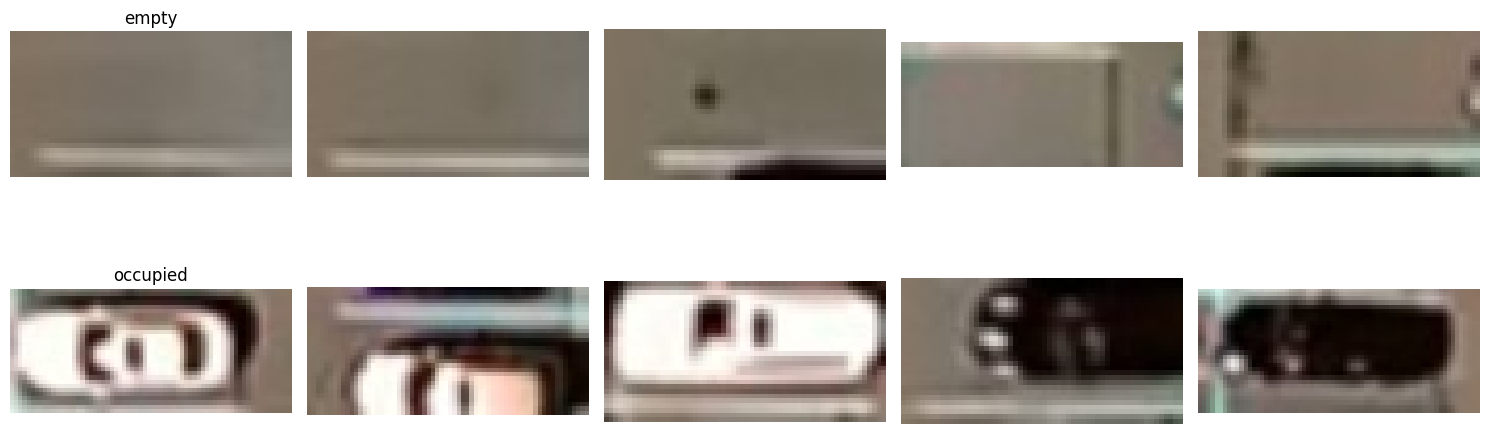

In [33]:
train_dir = 'train_data/train'
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 3 * len(class_names)))
if len(class_names) == 1:
    axes = [axes]

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dir, class_name)
    images = os.listdir(class_folder)
    sample_images = random.sample(images, min(5, len(images)))
    
    for j in range(5):
        ax = axes[i][j] if isinstance(axes[i], (list, np.ndarray)) else axes[i]
        ax.axis('off')
        if j < len(sample_images):
            img_path = os.path.join(class_folder, sample_images[j])
            img = Image.open(img_path)
            ax.imshow(img)
            if j == 0:
                ax.set_title(class_name, fontsize=12)
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()

Found 432 images belonging to 2 classes.


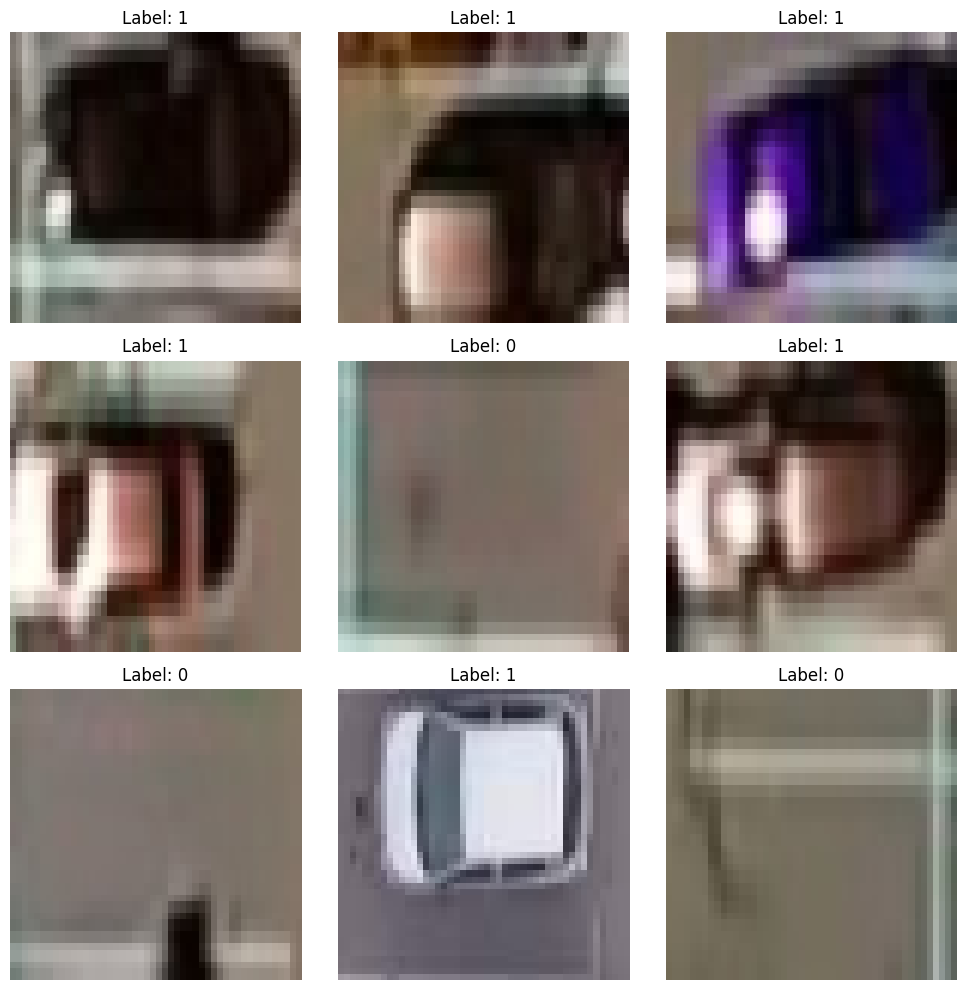

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Label: {}".format(np.argmax(labels[i])))
    plt.axis('off')
plt.tight_layout()
plt.show()

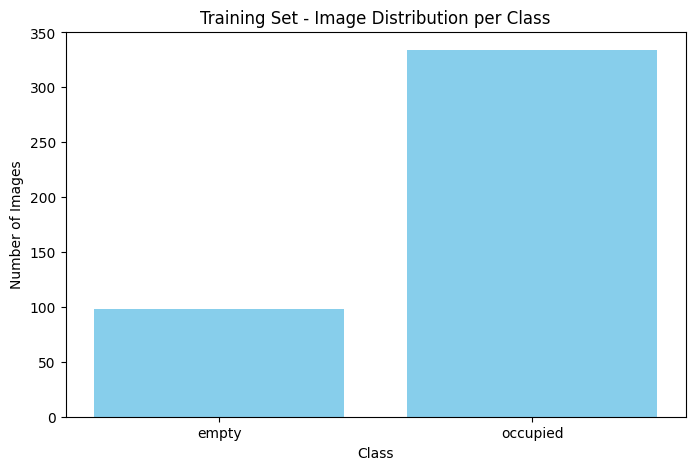

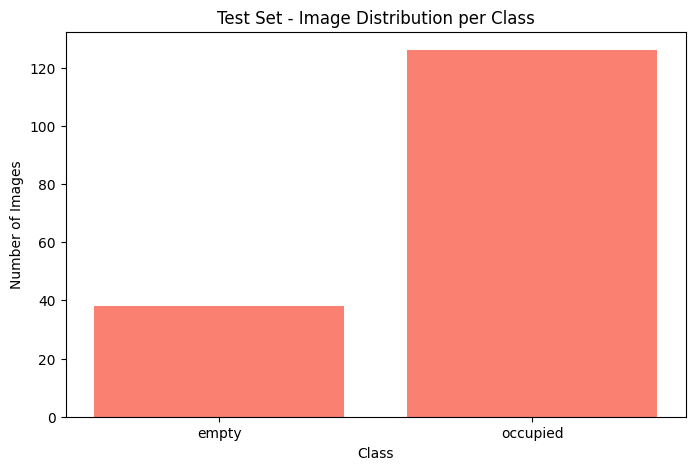

In [35]:
import matplotlib.pyplot as plt

def count_images(directory):
     total = 0
     class_counts = {}
     for class_name in os.listdir(directory):
         class_path = os.path.join(directory, class_name)
         if os.path.isdir(class_path):
             files = os.listdir(class_path)
             count = len(files)
             class_counts[class_name] = count
             total += count
     return total, class_counts


total_train, train_counts = count_images('train_data/train')
total_test, test_counts = count_images('train_data/test')

plt.figure(figsize=(8, 5))
plt.bar(list(train_counts.keys()), list(train_counts.values()), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Set - Image Distribution per Class")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(list(test_counts.keys()), list(test_counts.values()), color='salmon')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Test Set - Image Distribution per Class")
plt.show()

Load train & test files

In [40]:
files_train = 0
files_validation = 0
cwd = os.getcwd()
folder = 'train_data/train'

for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_train +=len(files)
    
folder = 'train_data/test'

for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
    files_validation +=len(files)

print(files_train, files_validation)

432 164


Set key parameters

In [41]:
img_width, img_height = 48,48
train_data_dir = 'train_data/train'
validation_data_dir = 'train_data/test'
nb_train_sample = files_train
nb_validation_sample = files_validation
batch_size = 32
epochs = 15
num_classes = 2

Build model on top of a pretrained VGG

In [42]:
model = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

In [43]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [44]:
for layer in model.layers[:10]:
    layer.traiable = False

In [45]:
x = model.output
x = Flatten()(x)

predictions = Dense(num_classes, activation='softmax')(x)
model_final = Model(inputs=model.input, outputs=predictions)

model_final.compile(loss='categorical_crossentropy', 
                    optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9), 
                    metrics=['accuracy'])

In [79]:
# Dataset summary
print("Number of Training Samples:", nb_train_sample)
print("Number of Validation Samples:", nb_validation_sample)
print("Image Dimensions:", img_width, "x", img_height)
print("Batch Size:", batch_size)
print("Epochs:", epochs)
print("Number of Classes:", num_classes)

# Model summary
print("\nFinal Model Summary:")
model_final.summary()

print("\nDetailed Model Layers Info:")
for i, layer in enumerate(model_final.layers):
    print(f"{i}: {layer.name} (Trainable: {layer.trainable})")

Number of Training Samples: 432
Number of Validation Samples: 164
Image Dimensions: 48 x 48
Batch Size: 32
Epochs: 15
Number of Classes: 2

Final Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,431,430 (112.27 MB)

 Trainable params: 14,715,714 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,715,716 (56.14 MB)


Detailed Model Layers Info:
0: input_layer_1 (Trainable: True)
1: block1_conv1 (Trainable: True)
2: block1_conv2 (Trainable: True)
3: block1_pool (Trainable: True)
4: block2_conv1 (Trainable: True)
5: block2_conv2 (Trainable: True)
6: block2_pool (Trainable: True)
7: block3_conv1 (Trainable: True)
8: block3_conv2 (Trainable: True)
9: block3_conv3 (Trainable: True)
10: block3_pool (Trainable: True)
11: block4_conv1 (Trainable: True)
12: block4_conv2 (Trainable: True)
13: block4_conv3 (Trainable: True)
14: block4_pool (Trainable: True)
15: block5_conv1 (Trainable: True)
16: block5_conv2 (Trainable: True)
17: block5_conv3 (Trainable: True)
18: block5_pool (Trainable: True)
19: flatten_2 (Trainable: True)
20: dense_2 (Trainable: True)


Data Augumentation

In [47]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, 
                   fill_mode='nearest',zoom_range=0.1, width_shift_range=0.1, 
                  height_shift_range=0.1, rotation_range=5)

test_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, 
                   fill_mode='nearest',zoom_range=0.1, width_shift_range=0.1, 
                  height_shift_range=0.1, rotation_range=5)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), 
                                 batch_size = batch_size, class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), 
                                 batch_size = batch_size, class_mode = 'categorical')

Found 432 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [49]:
history = model_final.fit(
    train_generator,
    steps_per_epoch=nb_train_sample // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_sample // batch_size,
    epochs=epochs
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - accuracy: 0.9854 - loss: 0.0485 - val_accuracy: 0.9125 - val_loss: 0.2137
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 0.9250 - val_loss: 0.1550
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.9879 - loss: 0.0448 - val_accuracy: 0.9375 - val_loss: 0.1377
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.9250 - val_loss: 0.1632
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - accuracy: 0.9867 - loss: 0.0521 - val_accuracy: 0.9187 - val_loss: 0.2088
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9688 - loss: 0.0671 - val_accuracy: 0.9187 - val_loss: 0.2006
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.9804 - loss: 0.0410 - val_accuracy: 0.9375 - val_loss: 0.1577
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9375

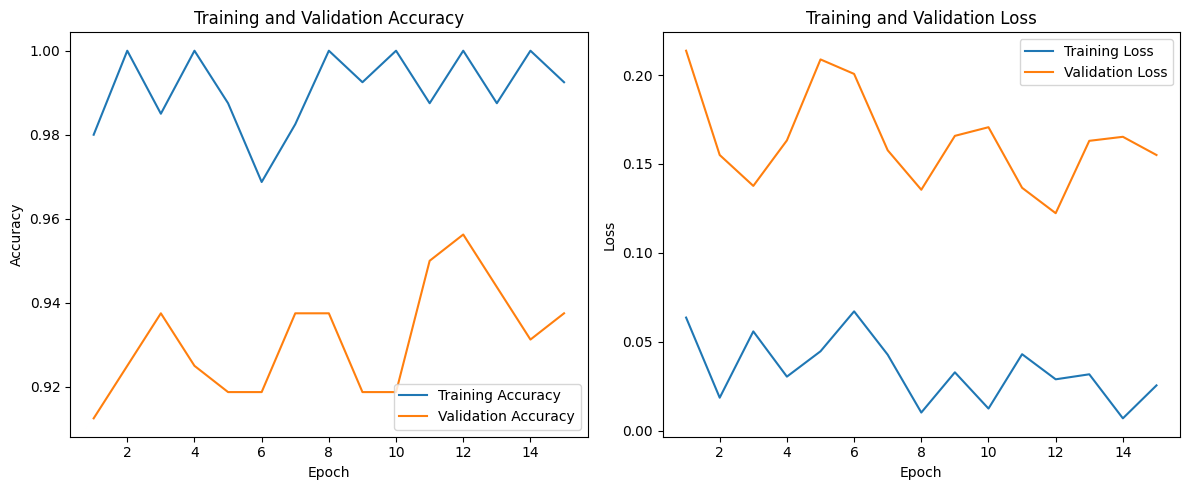

In [50]:
import matplotlib.pyplot as plt

# Extract training history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Found 164 images belonging to 2 classes.
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

/Users/rose/jupyter_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step 


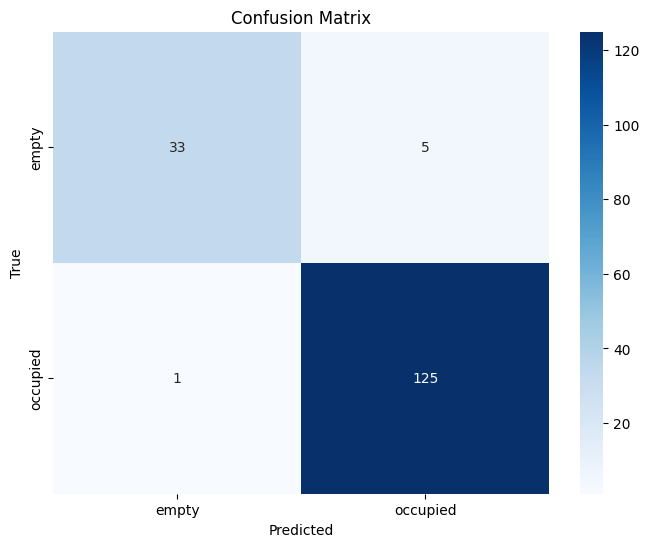

Classification Report:
              precision    recall  f1-score   support

       empty       0.97      0.87      0.92        38
    occupied       0.96      0.99      0.98       126

    accuracy                           0.96       164
   macro avg       0.97      0.93      0.95       164
weighted avg       0.96      0.96      0.96       164



In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

val_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

predictions = model_final.predict(val_generator, steps=val_generator.samples // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)
true_class_indices = val_generator.classes

cm = confusion_matrix(true_class_indices, predicted_class_indices)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(val_generator.class_indices.keys()), 
            yticklabels=list(val_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_class_indices, predicted_class_indices, 
                            target_names=list(val_generator.class_indices.keys())))

In [53]:
history.history

{'accuracy': [0.9800000190734863,
  1.0,
  0.9850000143051147,
  1.0,
  0.987500011920929,
  0.96875,
  0.9825000166893005,
  1.0,
  0.9925000071525574,
  1.0,
  0.987500011920929,
  1.0,
  0.987500011920929,
  1.0,
  0.9925000071525574],
 'loss': [0.06356945633888245,
  0.018490459769964218,
  0.055795375257730484,
  0.030349187552928925,
  0.04459618031978607,
  0.06706896424293518,
  0.04268719255924225,
  0.01014670915901661,
  0.032767508178949356,
  0.012378674931824207,
  0.04296468570828438,
  0.028843393549323082,
  0.0316605381667614,
  0.0068822456523776054,
  0.0254210215061903],
 'val_accuracy': [0.9125000238418579,
  0.925000011920929,
  0.9375,
  0.925000011920929,
  0.918749988079071,
  0.918749988079071,
  0.9375,
  0.9375,
  0.918749988079071,
  0.918749988079071,
  0.949999988079071,
  0.956250011920929,
  0.9437500238418579,
  0.9312499761581421,
  0.9375],
 'val_loss': [0.21369914710521698,
  0.15503068268299103,
  0.13765200972557068,
  0.16324272751808167,
  0.20

In [54]:
model_final.save('model_final.h5')

In [59]:
from tensorflow.keras.models import load_model

model_loaded = load_model('model_final.h5')
print("Model loaded from 'model_final.h5'.")


Model loaded from 'model_final.h5'.


In [60]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'train_data/test',  
    target_size=(48, 48),  
    batch_size=32,        
    class_mode='categorical',
    shuffle=False        
)



Found 165 images belonging to 2 classes.


In [61]:
test_loss, test_acc = model_loaded.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

/Users/rose/jupyter_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9299 - loss: 0.1970 

Test Loss: 0.1174
Test Accuracy: 0.9576


In [62]:
predictions = model_loaded.predict(test_generator)
predicted_class_indices = np.argmax(predictions, axis=1)
true_class_indices = test_generator.classes

print("\nClassification Report:")
class_labels = list(test_generator.class_indices.keys())
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_labels))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step 

Classification Report:
              precision    recall  f1-score   support

       empty       0.97      0.85      0.90        39
    occupied       0.95      0.99      0.97       126

    accuracy                           0.96       165
   macro avg       0.96      0.92      0.94       165
weighted avg       0.96      0.96      0.96       165



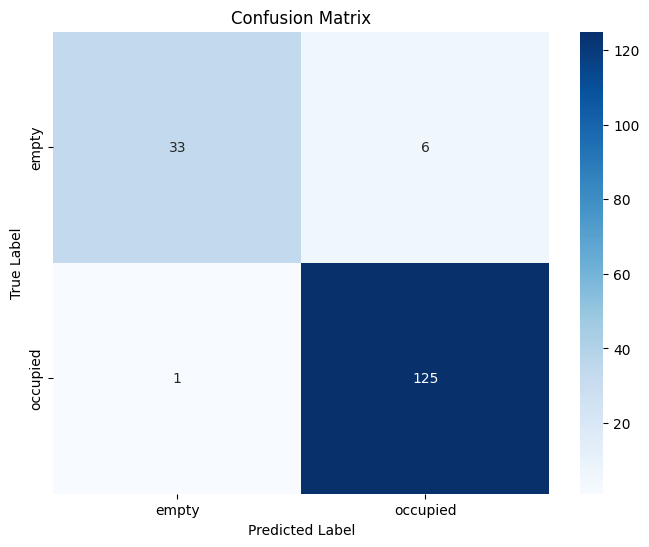

In [63]:
cm = confusion_matrix(true_class_indices, predicted_class_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

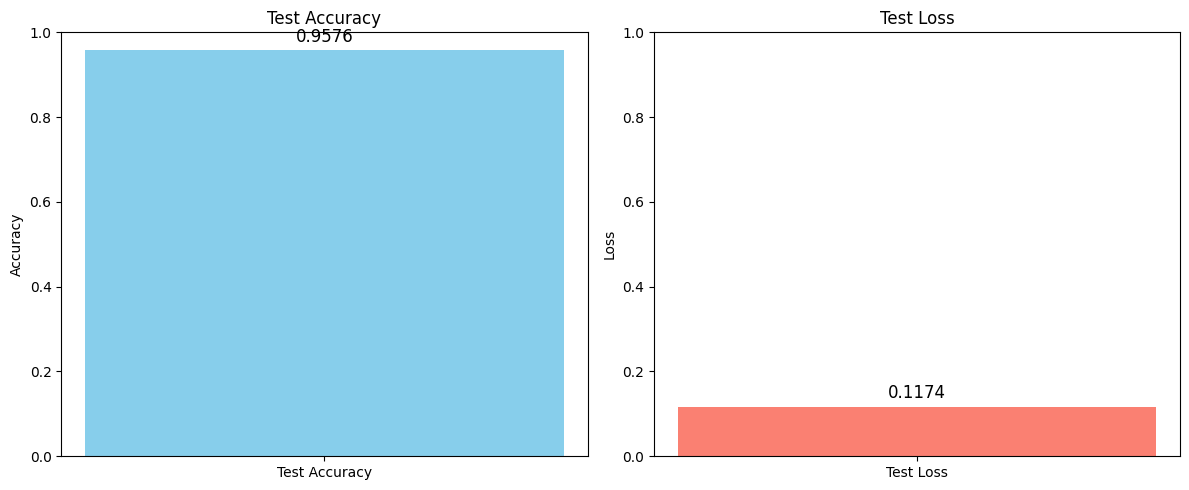

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(['Test Accuracy'], [test_acc], color='skyblue')
axes[0].set_ylim([0, 1])  
axes[0].set_title("Test Accuracy")
axes[0].set_ylabel("Accuracy")
# Annotate the bar with the exact value
axes[0].text(0, test_acc + 0.01, f"{test_acc:.4f}", ha='center', va='bottom', fontsize=12)

axes[1].bar(['Test Loss'], [test_loss], color='salmon')
axes[1].set_title("Test Loss")
axes[1].set_ylabel("Loss")

upper_bound = max(test_loss + 0.1, 1.0) if test_loss < 1 else test_loss + 0.5
axes[1].set_ylim([0, upper_bound])
axes[1].text(0, test_loss + 0.01, f"{test_loss:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

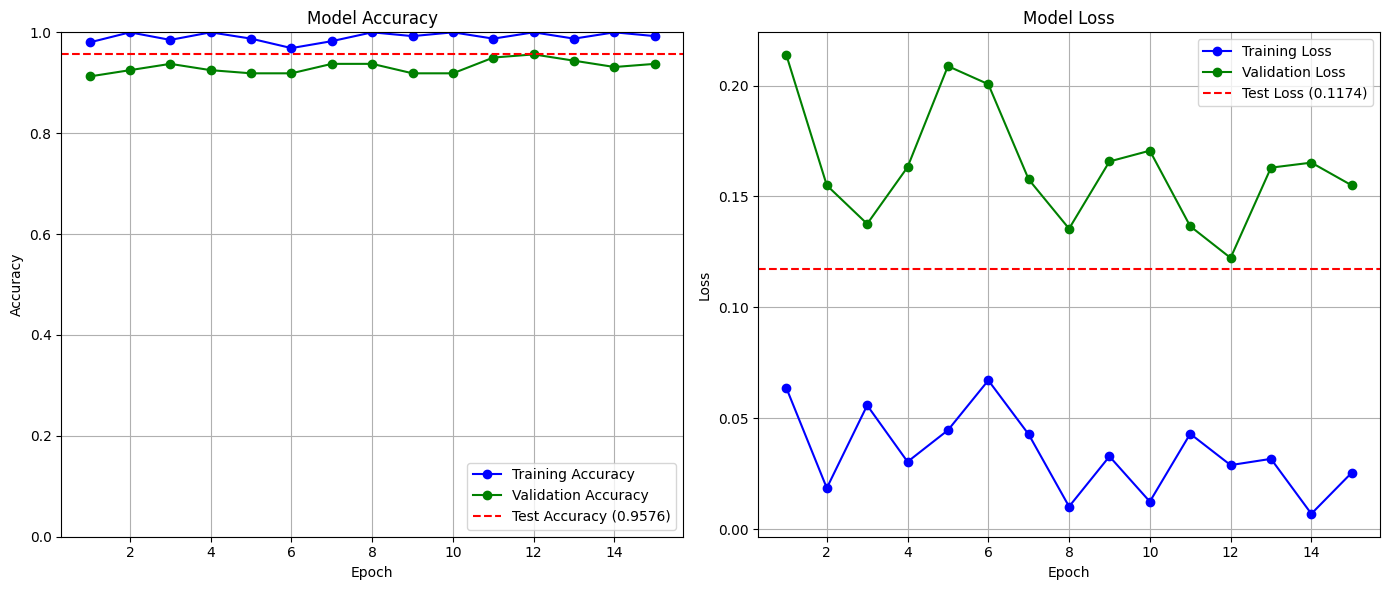

In [78]:
epochs_range = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


axes[0].plot(epochs_range, history.history['accuracy'], 
             label='Training Accuracy', marker='o', color='blue')
axes[0].plot(epochs_range, history.history['val_accuracy'], 
             label='Validation Accuracy', marker='o', color='green')

axes[0].axhline(y=test_acc, color='red', linestyle='--', 
                label=f'Test Accuracy ({test_acc:.4f})')

axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].grid(True)

axes[1].plot(epochs_range, history.history['loss'], 
             label='Training Loss', marker='o', color='blue')
axes[1].plot(epochs_range, history.history['val_loss'], 
             label='Validation Loss', marker='o', color='green')

axes[1].axhline(y=test_loss, color='red', linestyle='--', 
                label=f'Test Loss ({test_loss:.4f})')

axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [70]:
class_dictionary = {}
class_dictionary[0]  = 'no_car'
class_dictionary[1]  = 'car'

In [71]:
class_dictionary

{0: 'no_car', 1: 'car'}

Predictive System

In [72]:
import cv2
import numpy as np

def make_prediction(image):
    image = cv2.imread(image)
    image = cv2.resize(image, (48, 48))
    img = image/255
#     (1, 48, 48, 3) -> 4D Tensor
    img = np.expand_dims(img, axis = 0)
    
    class_predicted = model_final.predict(img)
    intId = np.argmax(class_predicted[0])
    label = class_dictionary[intId]
    return label

In [73]:
make_prediction("train_data/train/occupied/roi_1.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


'car'

In [76]:
make_prediction("train_data/test/empty/spot89.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'no_car'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


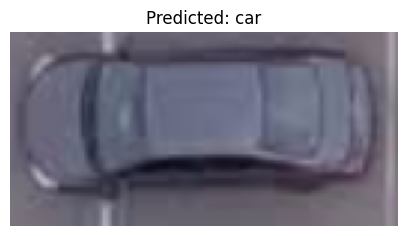

Prediction for image 1: car
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


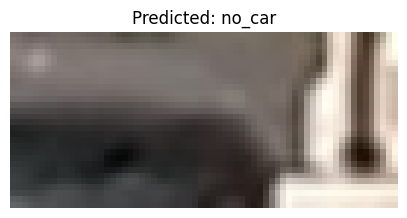

Prediction for image 2: no_car


In [77]:
def visualize_prediction(model, image_path, label_dict, target_size=(48,48)):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Error: Could not read image from {image_path}")
        return None
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    image_resized = cv2.resize(image_rgb, target_size)
    
    image_array = np.array(image_resized, dtype=np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    
    predictions = model.predict(image_array)
    class_index = np.argmax(predictions, axis=1)[0]
    class_label = label_dict[class_index]
    
    plt.figure(figsize=(5,5))
    plt.imshow(image_rgb)
    plt.title(f"Predicted: {class_label}")
    plt.axis('off')
    plt.show()
    
    return class_label

test_image_path_1 = "train_data/train/occupied/roi_1.png"
test_image_path_2 = "train_data/test/empty/spot89.jpg"  

label1 = visualize_prediction(model_final, test_image_path_1, class_dictionary)
print("Prediction for image 1:", label1)

label2 = visualize_prediction(model_final, test_image_path_2, class_dictionary)
print("Prediction for image 2:", label2)

In [29]:
model_final.save("model_final.h5")